<a href="https://colab.research.google.com/github/eugenemfu/DUL_HW/blob/main/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 384 (delta 120), reused 103 (delta 69), pack-reused 171
Receiving objects: 100% (384/384), 55.95 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=0df74f91abdec1bb73cda6b2a5a28e32a6af15fb7617dce5d905e8be7995e956
  Stored in directory: /tmp/pip-ephem-wheel-cache-gj9iym14/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [68]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from torchvision import transforms
from tqdm import tqdm

device = 'cuda'


class VAT(nn.Module): 
    def __init__(self):
        super().__init__()
        hidden = 128
        n_classes = 10
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden), 
            nn.ReLU(),
            nn.Linear(hidden, hidden), 
            nn.ReLU(),
            nn.Linear(hidden, n_classes)
        )
        self.d = Normal(torch.zeros((3, 32, 32)), torch.ones((3, 32, 32)))

    def forward(self, x):
        return self.linear(self.conv(x).flatten(1))

    def unlabeled_loss(self, x):
        with torch.no_grad():
            log_target = F.log_softmax(self(x), dim=1)
        r = 10 * F.normalize(self.d.sample((x.shape[0],)).to(device), dim=(1, 2, 3))
        r.requires_grad_()
        adv = F.kl_div(F.log_softmax(self(x + r), dim=1), log_target, log_target=True, reduction="batchmean")
        adv.backward()
        r_adv = F.normalize(r.grad, dim=(1, 2, 3))
        self.zero_grad()
        return F.kl_div(F.log_softmax(self(x + r_adv), dim=1), log_target, log_target=True, reduction="batchmean")
    
    def loss(self, x, labels):
        pred = self(x[labels != -1])
        loss_l = F.cross_entropy(pred, labels[labels != -1])
        loss_ul = self.unlabeled_loss(x)
        return loss_ul + loss_l

    @torch.no_grad()
    def acc(self, x, labels):
        pred = self(x[labels != -1])
        acc = (torch.argmax(pred, dim=1) == labels[labels != -1]).cpu().detach().numpy().mean()
        return acc

    def fit(self, train_data, test_data, n_epochs=15, lr=5e-4, batch_size=256):
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        opt = Adam(self.parameters(), lr=lr)

        losses = []
        accuracies = []
        for _ in tqdm(range(n_epochs)):
            for x, labels in train_dataloader:
                x = x.to(device)
                labels = labels.to(device)
                loss = self.loss(x, labels)
                opt.zero_grad()
                loss.backward()
                opt.step()
                losses.append(loss.item())
            
            accuracies_batch = []
            for x, labels in test_dataloader:
                x = x.to(device)
                labels = labels.to(device)
                acc = self.acc(x, labels)
                accuracies_batch.append(acc)
            accuracies.append(np.mean(accuracies_batch))
            
        return np.array(losses), np.array(accuracies)

In [69]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    model = VAT().to(device)
    loss, acc = model.fit(train_data, test_data, 10)
    return loss, acc

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [07:33<00:00, 45.31s/it]


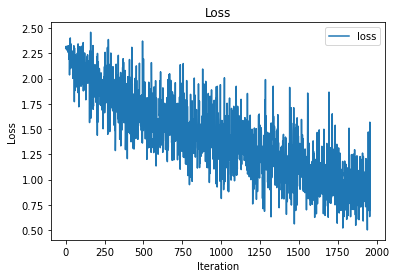

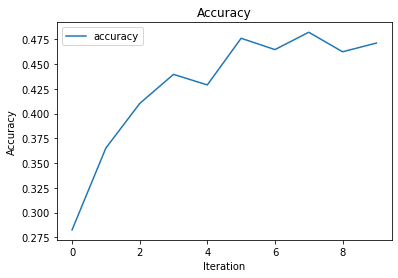

In [70]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """